## Lock Jun Lin 0125118

# Twitter Sentiment Analysis on COVID-19 Vaccine

### This notebook is ran through Google Colab. As such, the dataset is read from the Google Drive of the currently logged in google account with the given directory

This notebook is about the training of the Twitter Sentiment Analysis Model. BERT Model which is a Transformer (deep learning) model is used for developing the Sentiment Analysis Model. A pre-trained BERT model is applied and then fine-tuned using the tweet dataset which is the dataset to be used for fine tuning the BERT model in order to allow the model to perform sentiment analysis on tweets. The tweet dataset consists of total 70,000 tweets before cleaning with 4 different labels/classes: negative, neutral, positive, and irrelevant. The irrelevant class will be removed as it is not needed for the fine-tuning of the BERT model which results in the tweet dataset with 3 labels/classes.

The BERT model that will be used will be the __"bert-base-uncased"__ version of BERT model that is a pre-trained BERT model from Hugging Face which is the transformers python library that provides thousands of pretrained models to perform tasks on different modalities such as text, vision, and audio. The tokenizer that will be used for tokenizing the text data will be the “bert-base-uncased” version of BertTokenizer.

The “bert-base-uncased” version of BERT, which is the smaller model trained on lower-cased English text (with 12-layer, 768-hidden, 12-heads, 110M parameters). The following [website](https://huggingface.co/bert-base-uncased) is the official website with information regarding the “bert-base-uncased” version of BERT.

In [ ]:
#install transformers module for BERT model
!pip install transformers

In [ ]:
#install explainable AI module for transformer model
!pip install transformers-interpret

### Importing Libraries needed for developing the Sentiment Analysis Model for Tweets

In [ ]:
#import libraries needed for developing the model
import re
import numpy as np
import pandas as pd
import os, json
import random
from textwrap import wrap

#import torch for deep learning model training
import torch
import torch.nn.functional as F #import torch.nn.functional library for calculating prediction probability

#import seaborn and matplotlib library for plotting graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams

#import tokenizer for bert to tokenize text 
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup

from google.colab import drive 

from torch.utils.data import TensorDataset, random_split #splitting dataset
from transformers import BertForSequenceClassification, AdamW, BertConfig #for loading pre-trained bert model, create scheduler and optimizer
from transformers_interpret import SequenceClassificationExplainer  #library for explainable AI for transformer model
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler #convert dataset into iterable dataset

import time
import datetime

#warnings
import warnings
warnings.filterwarnings('ignore')

# configure graph style when plotting graph
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
#seed value for fixed randomizer
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.manual_seed(seed_val) #fixed seed for random splitting dataset

#display if there are any available "cuda" device on the device
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Read Tweet Dataset for training sentiment analysis model

The tweet dataset consists of around 70,000 rows of data before cleaning. The tweet dataset consists of columns: Tweet ID, entity, sentiment, Tweet content. The only columns that are needed for training the sentiment analysis model are the 'Tweet content' column and the 'sentiment' column as the 'Tweet content' column contains the text data of the tweet and the 'sentiment' column contains the label of the tweet. 

The tweet dataset contains 4 different labels or classes of tweets which are irrelevant tweets, negative tweets, neutral tweets, and positive tweets. The The type of tweets are according to the label of the tweets. Tweets that are labelled as 'Irrelevant' are remove as those are unnecessary for the fine-tuning of the BERT model. The BERT model is to classify tweets as positive, negative, or neutral.

The training dataset can be found from this [link](https://www.kaggle.com/tanujdhiman/twitter-sentiment-analysis/data).

The text data will first be tokenized before text cleaning. The text data of the tweet dataset will be cleaned by removing quotation marks, url links, removing additional spaces to leave only a single space, remove words and letter after the __"@"__ symbol which are usually @mention in tweets.

In [ ]:
#mount google drive to collab to access and read file (tweet dataset)
drive.mount('/content/gdrive') #user will be required to provide google drive access to google colab

# #alternative method: upload the dataset file
# from google.colab import files
# uploaded = files.upload()

#column names for the dataset
colnames = ['id', 'entity', 'sentiment', 'text']
df = pd.read_csv('/content/gdrive/MyDrive/dataset/twitter_training.csv', names=colnames, header=None)
df.head() #display first 5 rows of dataset

#retrieve neccessary column from tweet dataset for training model: text column and sentiment column
train = pd.DataFrame()
train['text']= df['text']
train['sentiment']=df['sentiment']

#remove empty rows that do not have data in any column
train = train.dropna()

#display if there is any rows without any data
train.isnull().sum()

#remove tweets labelled as "Irrelevant"
train = train[train.sentiment != 'Irrelevant']

#replacing label sentiment with value: negative sentiment = 0; neutral sentiment = 1; positive sentiment = 2
train['sentiment'] = train['sentiment'].replace(['Negative','Neutral','Positive'],[0,1,2])

Mounted at /content/gdrive


,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#retrieve neccessary column from tweet dataset for training model: text column and sentiment column
train = pd.DataFrame()
train['text']= df['text']
train['sentiment']=df['sentiment']

#remove empty rows that do not have data in any column
train = train.dropna()

#display if there is any rows without any data
train.isnull().sum()

#remove tweets labelled as "Irrelevant"
train = train[train.sentiment != 'Irrelevant']

#replacing label sentiment with value: negative sentiment = 0; neutral sentiment = 1; positive sentiment = 2
train['sentiment'] = train['sentiment'].replace(['Negative','Neutral','Positive'],[0,1,2])

In [ ]:
#load BERT tokenizer and display an example of how the tokenizer work
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes")))

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

['hello', '.', 'this', 'is', 'a', 'sample', 'statement', 'for', 'visual', '##isation', 'purposes']
[7592, 1012, 2023, 2003, 1037, 7099, 4861, 2005, 5107, 6648, 5682]


### Text Cleaning/Pre-processing

Text Cleaning is performed to remove unnecessary text data and convert raw text data into usable text data for model training. The URLs, __@mentions__, and quotation marks found in tweet are removed. Any additional spaces between words that can be found in tweet are converted into a single space. 

In [ ]:
max_len = 0
cleaned_text = []

#text cleaning and tokenize text data and retrieve maximum length of text among all tweets 
for tweet in train['text']:
    #The following code is used to clean the tweets by removing URLs, accounts, quotation marks,etc
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    cleaned_text.append(tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))  #maximum length of input ids

train['clean_text'] = cleaned_text
print('Max sequence length: ', max_len)

Max sequence length:  315


  ### The text data of the tweet dataset will be encoded into input id and attention masks

In [ ]:
input_ids = []
attention_masks = []

#encode text data of the tweet dataset into input id and attention mask
for sent in train['clean_text']:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

#store input id and attention mask into array
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['sentiment'].tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Splitting the dataset into training dataset and validation dataset

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)  #storing the input ids,masks and labels in dataset

#defining train size and test size
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  #80-20 train-val split

batch_size = 20  #batch size for iterable datasets

# convert training dataset and validation dataset into iterable dataset
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),     #random sampling in training
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),    #sequential sampling in validation
            batch_size = batch_size 
        )

### Define model, optimizer, and scheduler

In [ ]:
#pre-trained BERT model with number of labels (base model)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False,
    output_hidden_states = False,
)

#Adam optimizer for optimizing pre-trained BERT model
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

#scheduler for BERT model
sche_epochs = 4
total_steps = len(train_dataloader) * sche_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#function to convert time into defined format
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Model Training (Fine-Tuning Pre-trained BERT model 'bert-base-uncased')

The time taken to trained for each batch of data, the amount of training loss, the total amount of time took for training epoch, the accuracy score of the model, the amount of validation loss, the amount of time took for validation, and the total amount of time taking for completing the training of the model.

In [ ]:
epochs=3  #number of epoch (number of times of training repeatedly with dataset)
model.to(device)
training_stats = []
total_t0 = time.time()

#fine-tuning BERT model based on number of epoch defined
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Printing the progress after every 40 batch
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,445.    Elapsed: 0:01:42.
  Batch    80  of  2,445.    Elapsed: 0:03:24.
  Batch   120  of  2,445.    Elapsed: 0:05:06.
  Batch   160  of  2,445.    Elapsed: 0:06:48.
  Batch   200  of  2,445.    Elapsed: 0:08:30.
  Batch   240  of  2,445.    Elapsed: 0:10:11.
  Batch   280  of  2,445.    Elapsed: 0:11:53.
  Batch   320  of  2,445.    Elapsed: 0:13:35.
  Batch   360  of  2,445.    Elapsed: 0:15:17.
  Batch   400  of  2,445.    Elapsed: 0:16:59.
  Batch   440  of  2,445.    Elapsed: 0:18:41.
  Batch   480  of  2,445.    Elapsed: 0:20:23.
  Batch   520  of  2,445.    Elapsed: 0:22:05.
  Batch   560  of  2,445.    Elapsed: 0:23:47.
  Batch   600  of  2,445.    Elapsed: 0:25:28.
  Batch   640  of  2,445.    Elapsed: 0:27:10.
  Batch   680  of  2,445.    Elapsed: 0:28:52.
  Batch   720  of  2,445.    Elapsed: 0:30:34.
  Batch   760  of  2,445.    Elapsed: 0:32:16.
  Batch   800  of  2,445.    Elapsed: 0:33:58.
  Batch   840  of

### Training and Validation Loss Curve

This graph shows the changes in learning performance over time in terms of experience. It also visualizes the training and validation loss during the training of the model to determine if the model is facing issues such as overfitting or underfitting or whether the model is well-fitted and can be deployed for real-life application usage. This graph can also determine if the training and validation datasets are suitably representative.

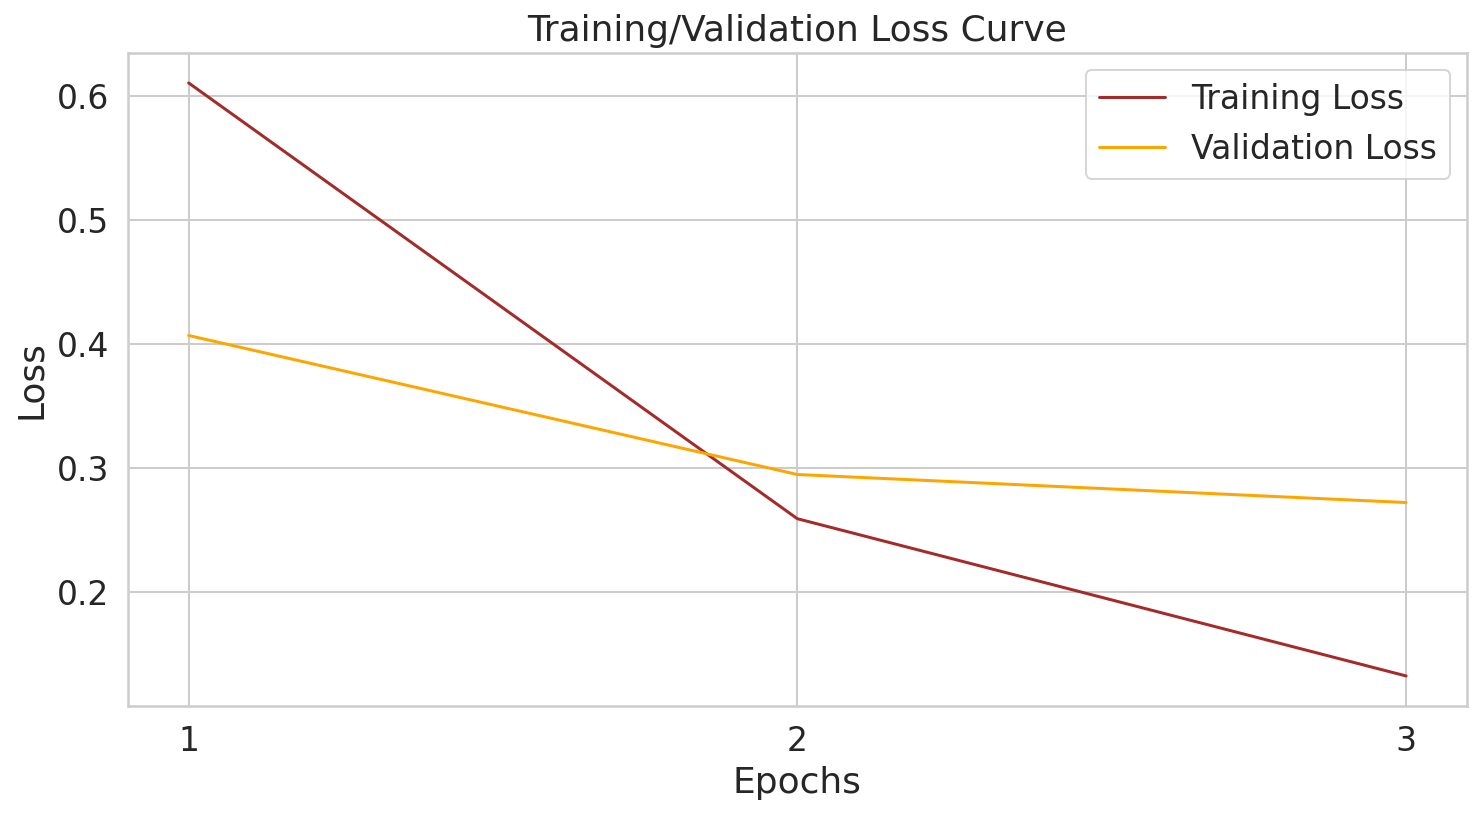

In [ ]:
#get training loss and validation loss
t_loss, v_loss, e = [] , [], []
for i in range(len(training_stats)):
  e.append(i + 1)
  t_loss.append(training_stats[i]['Training Loss'])
  v_loss.append(training_stats[i]['Valid. Loss'])

#plot the training/validation loss curve graph
fig = plt.figure(figsize = (12,6))
plt.plot(e, t_loss, color='brown', label='Training Loss')
plt.plot(e, v_loss, color='orange', label='Validation Loss')
plt.title('Training/Validation Loss Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(e)
plt.legend()
plt.show()

### Model Information (show each layer and its information of the model)

In [ ]:
#display information regarding BERT model after fine tuning
print(model)

### Model Evaluation Metrics (Precision, Recall, F1-Score, Accuracy, Confusion Matrix)

In [ ]:
#perform prediction on the tweet of the validation dataset for calculating evaluation metrics and confusion matrix
predictions = [] #array to store prediction of tweets in validation dataset

for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        pred_result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)
      
    logits = pred_result.logits
    logits = logits.detach().cpu().numpy()
    logits=np.argmax(logits,axis=1)
    for i in range(len(logits)):
      predictions.append(logits[i])

#retrieve true/actual label of the tweet in the validation dataset 
true_pred = [t.item() for t in val_dataset[:][2]]

#display classification report with evaluation metric: precision, recall, and f1-score
class_names = ['negative', 'neutral', 'positive']
print(classification_report(true_pred, predictions, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.93      0.94      0.94      4456
     neutral       0.93      0.91      0.92      3595
    positive       0.91      0.93      0.92      4174

    accuracy                           0.93     12225
   macro avg       0.93      0.93      0.93     12225
weighted avg       0.93      0.93      0.93     12225



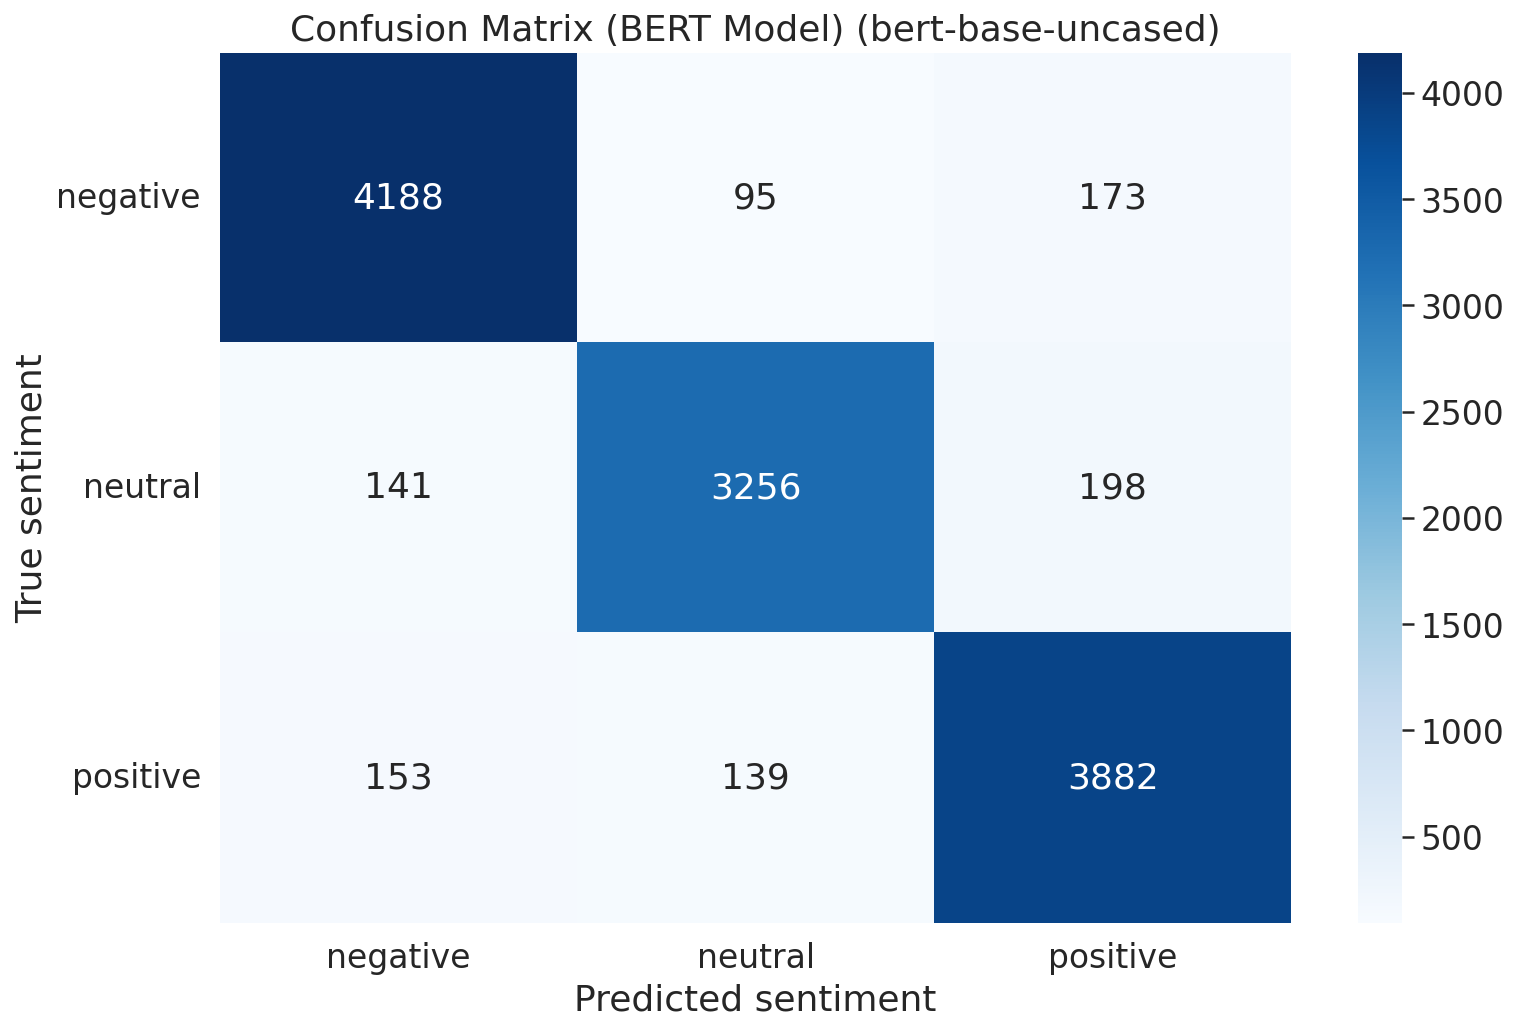

In [ ]:
#function for display confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='center')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  plt.title("Confusion Matrix (BERT Model) (bert-base-uncased)")

#display confusion matrix with defined style
cm = confusion_matrix(true_pred, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Tweet Input Prediction with Model (Explainable AI applied)

The prediction probability of the input tweet will be display in a side bar chart showing the probability across 3 different classes. An Explainable AI is also applied to give clarity and visualize on the prediction made by the model in order for much deeper comprehension on the model to build greater trust towards the model.

In [ ]:
pred_input_ids = []
pred_attention_masks = []

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#choose which tweet from dataset as example for tweet input prediction
idx = 11111 

#encode the tweet input into input id and attention mask    
encoded_dict = tokenizer.encode_plus(
                    train.text.iloc[idx],                      
                    add_special_tokens = True, 
                    max_length = 110,           
                    pad_to_max_length = True,
                    return_attention_mask = True,   
                    return_tensors = 'pt',     
                )
  
pred_input_ids.append(encoded_dict['input_ids'])
pred_attention_masks.append(encoded_dict['attention_mask'])

pred_input_ids = torch.cat(pred_input_ids, dim=0)
pred_attention_masks = torch.cat(pred_attention_masks, dim=0)

#convert encoded tweet input into iterable dataset with defined batch size
tweet_input = TensorDataset(pred_input_ids, pred_attention_masks)

batch_size = 32

vax_dataloader = DataLoader(
            tweet_input,  
            sampler = SequentialSampler(tweet_input),     #Sequential Sampling
            batch_size = batch_size 
        )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
#perform prediction on tweet input
predictions = [] #array to store prediction probability of tweet input

for batch in vax_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
      pred_result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = pred_result.logits
  logits = logits.detach().cpu().numpy()
  logits=np.argmax(logits,axis=1)
  for i in range(len(logits)):
    predictions.append(logits[i])

Input Tweet: As of now right now ONLY single data am happy about with @NBA2K is pack openings. The shootings shit shit trash! Yet i waited 64 hrs to get my bonus content. This is complete bullshit.
True sentiment: negative



(0.0, 1.0)

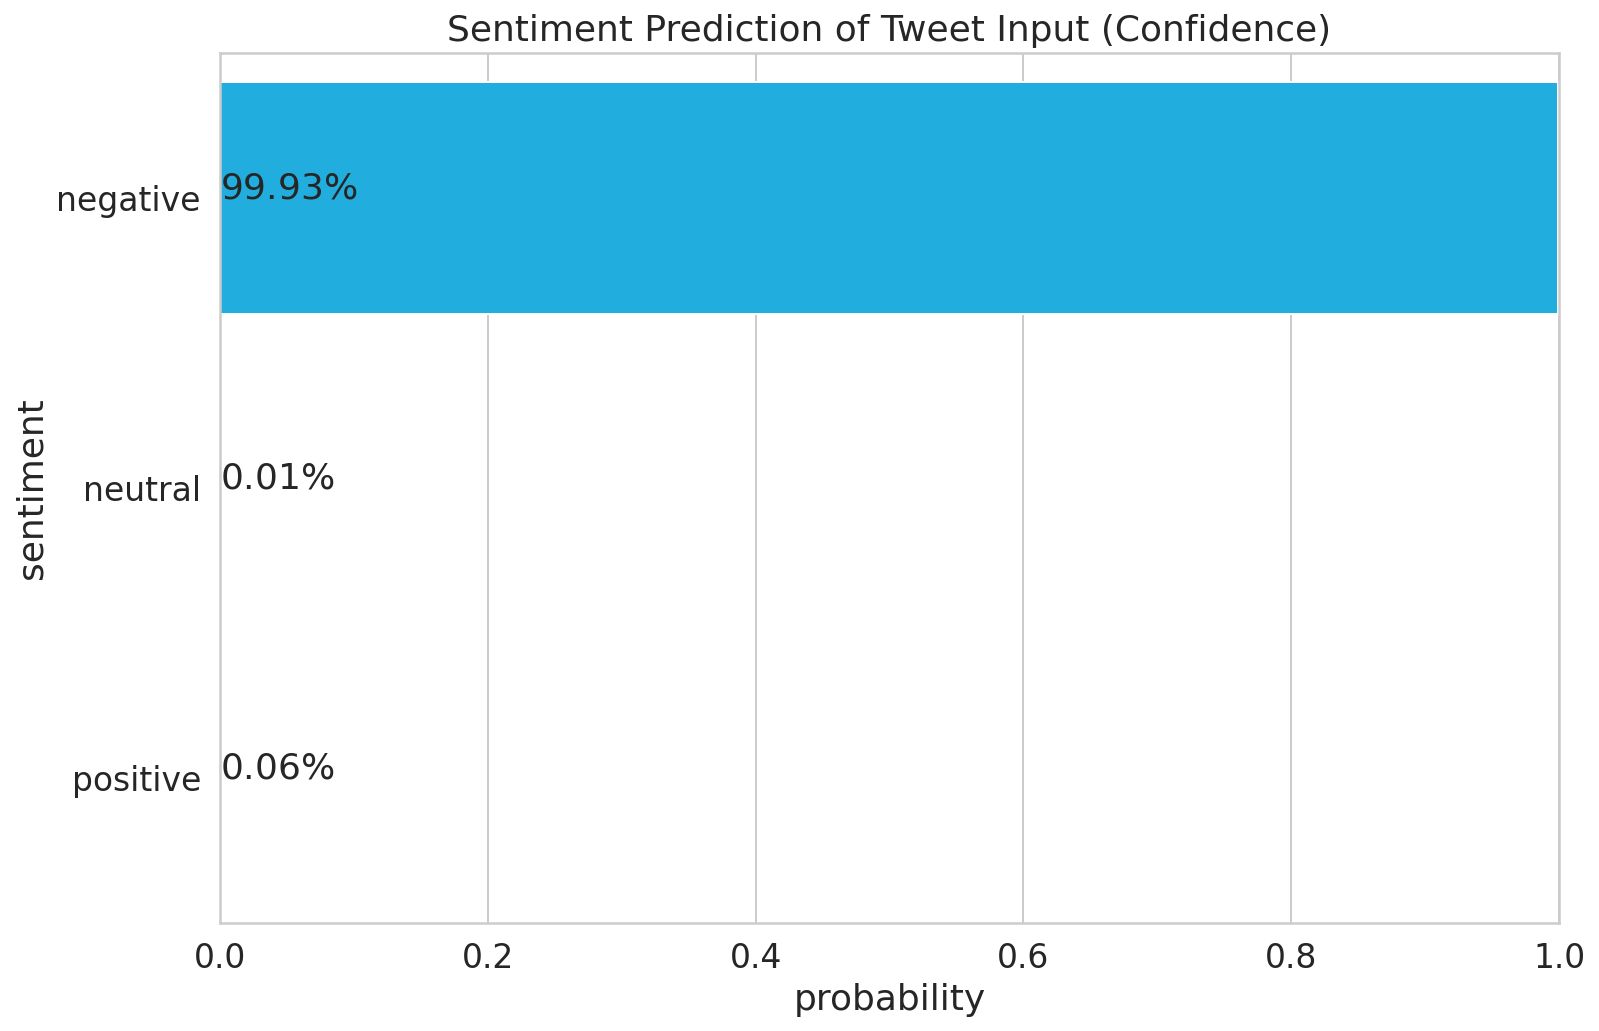

In [ ]:
# retrieve the probability prediction of the tweet input by the model
proba = F.softmax(pred_result.logits, dim=1)[0].tolist()

#display side bar graph with prediction probability of tweet input
review_text = train.text.iloc[idx]
true_sentiment = train.sentiment.iloc[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': proba })
print("Input Tweet:", review_text)
print(f'True sentiment: {class_names[true_sentiment]}\n') #sentiment for tweet example retrieved from dataset (comment if unnecessary)
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
#value of probability prediction (converted into percentage)
plt.text(0, 0, r'${0:2.2f}\%%$'.format(proba[0]*100))
plt.text(0, 1, r'${0:2.2f}\%%$'.format(proba[1]*100))
plt.text(0, 2, r'${0:2.2f}\%%$'.format(proba[2]*100))
plt.title('Sentiment Prediction of Tweet Input (Confidence)')
plt.ylabel('sentiment')
plt.xlabel('probability (confidence)')
plt.xlim([0, 1])

In [ ]:
#display explainable AI on prediction of input tweet by the model
cls_explainer = SequenceClassificationExplainer(model, tokenizer)
attributions = cls_explainer(train.text.iloc[idx])

#replace numerical label with corresponding sentiment label
if cls_explainer.predicted_class_name == 'LABEL_0':
  print("Predicted Sentiment: Negative (Label_0) \n")
elif cls_explainer.predicted_class_name == 'LABEL_1':
  print("Predicted Sentiment: Neutral (Label_1)\n")
elif cls_explainer.predicted_class_name == 'LABEL_2':
  print("Predicted Sentiment: Positive (Label_2)\n")

print(attributions)
cls_explainer.visualize("distilbert_example.html")

Predicted Sentiment: Negative (Label_0) 

[('[CLS]', 0.0), ('as', -0.02287867047449467), ('of', -0.07468736467873247), ('now', 0.11278342532173642), ('right', -0.1265506738640539), ('now', 0.09657698558404275), ('only', 0.1892839547565096), ('single', 0.04660899621328041), ('data', 0.097264266826233), ('am', -0.04289420429922602), ('happy', -0.3600949349355141), ('about', -0.028827334689334676), ('with', 0.05996582402196619), ('@', -0.0438812898531918), ('nba', 0.05901474383495794), ('##2', 0.08262523285309804), ('##k', -0.11607748216521482), ('is', 0.0020003006588252097), ('pack', -0.0012848344801444675), ('openings', -0.026953494696254836), ('.', 0.1431889456866922), ('the', 0.0011309756215409797), ('shooting', -0.053606087789875516), ('##s', 0.000747546144778156), ('shit', 0.00365587343011193), ('shit', 0.012320022331095075), ('trash', 0.12000209795377159), ('!', 0.01713217224645145), ('yet', -0.001923368788709208), ('i', -0.05287848827883335), ('waited', 0.017398785469633863), ('64

### Model Saving and Loading (model will be saved to google drive as this notebook is ran on googgle colab)

The model is saved by using the save method from torch to the given filepath destination. The model is saved as a __'.pt'__ or __Panther Project Format files__. The model can be easily loaded by specifying the filepath destination and using the load method from torch.

In [ ]:
#define destination file path  to save model (this will save to drive as the notebook is ran on Google Colab) 
path = F"/content/gdrive/MyDrive/dataset/model/tweet_bert_model.pt" 
torch.save(model, path)

#load model from destination file path
load_model = torch.load('/content/gdrive/MyDrive/dataset/model/tweet_bert_model.pt')

### Conclusion

BERT model is able to perform really well compared to logistic regression algorithm. However, the multinomial naive bayes algorithm has proven to be a better method to use for training the Twitter sentiment analysis model. The bert model that was used for this developing the twitter sentiment analysis model was pre-trained. As such, fine-tuning was only required in order to train the model to perform the specific task stated which is sentiment analysis. 

The performance of the BERT model may improve as the number of epochs increase; however due to time and resource constraint it is only able to perform 3 epochs at max. The twitter sentiment analysis model with multinomial naive bayes algorithm may have proven to have much higher evaluation metrics score but BERT model will be chosen to be deployed for real-world usage/application. The BERT model is able take into account the context of the tweet which is able to give a much accurate and desirable prediction. The multinomial naive bayes performs prediction by looking at the words and determine the sentiment of the tweet according to the nature of the words. The chosen model will be performing sentiment analysis on the Covid-19 vaccine tweets.

# Sentiment prediction on Covid-19 vaccine tweets

The Covid-19 vaccine tweets are a tweet dataset that contains only Covid-19 vaccine related tweets that are scrapped and collected from Twitter using the __tweepy__ Python module to gain access to Twitter API. The Covid-19 vaccine tweets were scraped by a certain individual and was uploaded to kaggle which can be downloaded from there. Click on this [website](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets) which contains the Covid-19 vaccine tweet dataset as well as more information regarding the dataset. 

The Covid-19 vaccine tweet dataset contains columns: id, user_name, user_location, user_description, user_created, user_followers, user_friends, user_friends, user_favourites, user_verified, and date. This was done to understand the public's consensus on the Covid-19 vaccine. The sentiment of the Covid-19 vaccine tweet will be predicted using the fine-tuned BERT model that is meant for sentiment analysis.

The text of the Covid-19 vaccine tweet and the predicted sentiment of the Covid-19 vaccine tweet will be store into a new csv file. The Covid-19 vaccine tweet will also be label according to the type of Covid-19 vaccine which is the subject of the tweet. Then, the dataset with the sentiment of the Covid-19 vaccine tweet can be used to analyze the public' consensus on Covid-19 vaccine. 

In [ ]:
#mount google drive to collab to access and read file (tweet dataset)
drive.mount('/content/gdrive') #user will be required to provide google drive access to google colab

Mounted at /content/gdrive


### Read Dataset

After the dataset is read from the given filepath destination, all unnecessary columns are removed from the datasets and only columns that are needed are transfer into a new dataframe. Then, only tweets ranging from the latest date in the dataset to 6 months before the latest date are taken to be analyzed. The 'text' data from the dataset will be input into the model to be analyze and predict the sentiment of the Covid-19 vaccine tweet. 

In [ ]:
#read the Covid-19 vaccine tweet dataset
df_vax = pd.read_csv('/content/gdrive/MyDrive/dataset/vaccination_all_tweets.csv')

#load model from destination file path
load_model = torch.load('/content/gdrive/MyDrive/dataset/model/tweet_bert_model.pt')

#drop unnecessary column in dataset
vax= df_vax.drop(['user_name','user_description','user_created','user_followers','user_friends',
                  'user_favourites','source','is_retweet','retweets','favorites', 'user_verified'],axis=1)

#convert date column to data data type with only date
vax['date'] = pd.to_datetime(vax['date']).dt.date
vax['date'] = pd.to_datetime(vax['date'])

#retrieve tweet within the last 6 months starting from the latest date in dataset
mask = (vax['date'] > '2021-5-23') & (vax['date'] <= '2021-11-23')
vax = vax.loc[mask]

#retrieve only tweet from the Covid-19 vaccine tweet dataset
vax_tweets= vax['text']
vax.reset_index(drop = True, inplace = True)
vax.head()

,id,user_location,date,text,hashtags
0,1396819543234736129,"Jaipur, India",2021-05-24,Discussions underway with GOI for supply of #P...,['PfizerBioNTech']
1,1396819242905837568,"Mumbai, India",2021-05-24,Pfizer-BioNTech COVID-19 Vaccine in India Soon...,['PfizerVaccine']
2,1396795781714268161,"Dubai, UAE",2021-05-24,The @DHA_Dubai has opened up appointments for ...,['PfizerBioNtech']
3,1396795009022586881,"Jaipur, India",2021-05-24,#Pfizer’s discussions with the Government of I...,"['Pfizer', 'PfizerBioNTech']"
4,1396768142299332608,"Mumbai, India",2021-05-24,#PfizerBioNTech is better than #AstraZenaca In...,"['PfizerBioNTech', 'AstraZenaca']"


### Tokenize Tweet/Text Data

The Covid-19 vaccine tweet will be tokenize before the tweet can be analyze by the model to predict the sentiment of the tweet. The tweet will be encoded into input ids and attention masks.

In [ ]:
#load BERT tokenizer and display an example of how the tokenizer work
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes")))

Loading BERT tokenizer...
['hello', '.', 'this', 'is', 'a', 'sample', 'statement', 'for', 'visual', '##isation', 'purposes']
[7592, 1012, 2023, 2003, 1037, 7099, 4861, 2005, 5107, 6648, 5682]


In [ ]:
#encode tweet text data
vax_input_ids = []
vax_attention_masks = []

for v_sent in vax_tweets:
    encoded_dict = tokenizer.encode_plus(
                        v_sent,                      
                        add_special_tokens = True, 
                        max_length = 315,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )

    vax_input_ids.append(encoded_dict['input_ids'])
    vax_attention_masks.append(encoded_dict['attention_mask'])

vax_input_ids = torch.cat(vax_input_ids, dim=0)
vax_attention_masks = torch.cat(vax_attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Prediction on Covid-19 Vaccine Tweets

After loading the model, the tweet will be analyzed by the model to predict the sentiment of the tweet. Then, the dataset with the predicted sentiment for the tweets will be save/wrote to the defined filepath destination. 

In [ ]:
#convert input_ids and attention_masks of Covid-19 vaccine tweets into dataset and change into batches to feed into model to analyze tweet and predict sentiment
vax_dataset= TensorDataset(vax_input_ids, vax_attention_masks)
vax_batch_size = 32
vax_dataloader = DataLoader(
            vax_dataset,  
            sampler = SequentialSampler(vax_tweets),     #Sequential Sampling
            batch_size = vax_batch_size 
        )

In [ ]:
#sentiment analysis on Covid-19 vaccine tweet
print('Predicting sentiments for {:,} Covid-19 vaccine tweets...'.format(len(vax_input_ids)))
load_model.eval()
vax_predictions = []
t0 = time.time()

for step, batch in enumerate(vax_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      vax_result = load_model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)  
  #keep track of number of tweets predicted and time taken
  if step % 60 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(vax_dataloader), elapsed))
  vax_logits = vax_result.logits
  vax_logits = vax_logits.detach().cpu().numpy()
  vax_logits = np.argmax(vax_logits,axis=1)
  for i in range(len(vax_logits)):
    vax_predictions.append(vax_logits[i])
print('\nDONE. Total Time Taken: {:}'.format(elapsed))

vax['sentiment'] = vax_predictions
vax['sentiment'] = vax['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'}) #change numerical label back to string label
#save dataset to define filepath destination
vax.to_csv("/content/gdrive/MyDrive/dataset/predicted_vaccination_tweets.csv", index=False)
vax.head()

In [ ]:
vax['sentiment'] = vax_predictions
vax['sentiment'] = vax['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'}) #change numerical label back to string label
#save dataset to define filepath destination
vax.to_csv("/content/gdrive/MyDrive/dataset/predicted_vaccination_tweets.csv", index=False)
vax.head()

,id,user_location,date,text,hashtags,sentiment
0,1396819543234736129,"Jaipur, India",2021-05-24,Discussions underway with GOI for supply of #P...,['PfizerBioNTech'],neutral
1,1396819242905837568,"Mumbai, India",2021-05-24,Pfizer-BioNTech COVID-19 Vaccine in India Soon...,['PfizerVaccine'],neutral
2,1396795781714268161,"Dubai, UAE",2021-05-24,The @DHA_Dubai has opened up appointments for ...,['PfizerBioNtech'],neutral
3,1396795009022586881,"Jaipur, India",2021-05-24,#Pfizer’s discussions with the Government of I...,"['Pfizer', 'PfizerBioNTech']",neutral
4,1396768142299332608,"Mumbai, India",2021-05-24,#PfizerBioNTech is better than #AstraZenaca In...,"['PfizerBioNTech', 'AstraZenaca']",positive
